In [324]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from pathlib import Path
import sqlite3

from astropy.coordinates import Distance, EarthLocation, ICRS
from astropy.time import Time
from astropy.table import QTable, join, unique
import astropy_healpix as ah
from astropy import units as u
from m4opt.fov import footprint_healpix
from matplotlib import pyplot as plt
from matplotlib import patheffects
from matplotlib.colors import LinearSegmentedColormap
from m4opt.missions import uvex as mission
from m4opt.models import observing, DustExtinction
import ligo.skymap
from ligo.skymap import distance
from ligo.skymap.io import read_sky_map
from ligo.skymap.bayestar import rasterize
import numpy as np
import seaborn as sns
from scipy import stats
import synphot
from tqdm.auto import tqdm

from rate_stats import format_with_errorbars, poisson_lognormal_rate_quantiles

ligo.skymap.omp.num_threads = 1

ImportError: cannot import name 'format_with_errorbars' from 'rate_stats' (/home/lsinger/m4opt-paper/scripts/rate_stats.py)

In [29]:
base_path = Path('/home/lsinger/lustre/runs_SNR-10')
runs = ['O5HLVK', 'O6HLVK']

In [31]:
# Read summary data for all events
event_tables_by_run = {}
for run in runs:
    event_table = join(
        QTable.read(base_path / run / 'farah' / 'allsky.dat', format='ascii'),
        QTable.read(base_path / run / 'farah' / 'injections.dat', format='ascii'),
    )
    assert (event_table['coinc_event_id'] == np.arange(len(event_table))).all()
    event_tables_by_run[run] = event_table

In [37]:
# Read all observing plans
plans_by_run = {}
for run, event_table in event_tables_by_run.items():
    plans_by_run[run] = plans = [QTable.read(base_path / run / 'farah' / 'allsky' / f'{i}.ecsv') for i in tqdm(range(len(event_tables_by_run[run])))]

    # Save objective values for all plans
    event_table['objective_value'] = [plan.meta['objective_value'] for plan in plans]

# Get planner arguments (doesn't matter which event)
plan_args = {**plans[0].meta['args']}
plan_args.pop('skymap')

hpx = ah.HEALPix(nside=plan_args['nside'], frame=ICRS(), order='nested')

  0%|          | 0/6325 [00:00<?, ?it/s]

  0%|          | 0/7541 [00:00<?, ?it/s]

In [52]:
def get_detection_probability_known_position(plan, event_row):
    if len(plan) == 0:
        return 0

    observations = plan[plan['action'] == 'observe'].filled()
    coords = observations['target_coord'].to_table()
    coords['i'] = np.arange(len(coords))
    i = np.sort(unique(coords, keys=['ra', 'dec'])['i'])
    fields = observations[i]

    target_ipix = hpx.lonlat_to_healpix(event_row['longitude'] * u.rad, event_row['latitude'] * u.rad)
    target_in_field = [target_ipix in footprint for footprint in footprint_healpix(hpx, mission.fov, fields['target_coord'], fields['roll'])]
    fields = fields[target_in_field]
    if len(fields) == 0:
        return 0

    with observing(
        observer_location=fields['observer_location'],
        target_coord=fields['target_coord'],
        obstime=(fields['start_time'] + 0.5 * fields['duration'])
    ):
        spectrum = synphot.SourceSpectrum(synphot.ConstFlux1D, amplitude=0 * u.ABmag) * synphot.SpectralElement(DustExtinction())
        limmag = mission.detector.get_limmag(
            plan_args['snr'],
            fields['duration'],
            spectrum,
            plan_args['bandpass']
        ).max()
    lim_absmag = limmag - Distance(event_row['distance'] * u.Mpc).distmod
    return stats.norm(loc=plan_args['absmag_mean'], scale=plan_args['absmag_stdev']).cdf(lim_absmag.to_value(u.mag))

for event_table, plans in zip(event_tables_by_run.values(), plans_by_run.values()):
    event_table['detection_probability_known_position'] = [get_detection_probability_known_position(plan, event_row) for plan, event_row in zip(tqdm(plans), event_table)]

  0%|          | 0/6325 [00:00<?, ?it/s]

/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/astropy/utils/masked/core.py:848: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)


  0%|          | 0/7541 [00:00<?, ?it/s]

/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/astropy/utils/masked/core.py:848: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)


In [99]:
def get_detection_probability_unknown_position(plan, skymap_moc):
    if len(plan) == 0:
        return 0

    skymap = rasterize(skymap_moc, order=ah.nside_to_level(plan_args['nside']))

    observations = plan[plan['action'] == 'observe'].filled()
    coords = observations['target_coord'].to_table()
    coords['i'] = np.arange(len(coords))
    i = np.sort(unique(coords, keys=['ra', 'dec'])['i'])
    fields = observations[i]

    durations = np.zeros(hpx.npix)
    for ipix, duration in zip(footprint_healpix(hpx, mission.fov, fields['target_coord'], fields['roll']), fields['duration'].to_value(u.s)):
        durations[ipix] = np.maximum(durations[ipix], duration)
    skymap['duration'] = durations * u.s
    skymap['ipix'] = np.arange(hpx.npix)

    skymap = skymap[durations > 0]

    with observing(
        observer_location=plan['observer_location'][0],
        target_coord=hpx.healpix_to_skycoord(skymap['ipix']),
        obstime=plan['start_time'][0]
    ):
        spectrum = synphot.SourceSpectrum(synphot.ConstFlux1D, amplitude=0 * u.ABmag) * synphot.SpectralElement(DustExtinction())
        skymap['limmag'] = mission.detector.get_limmag(
            plan_args['snr'],
            skymap['duration'],
            spectrum,
            plan_args['bandpass']
        )
    skymap['limmag'][np.isnan(skymap['limmag'])] = -np.inf * u.mag

    distmean, diststd, distnorm = distance.parameters_to_moments(skymap['DISTMU'], skymap['DISTSIGMA'])
    sigma2_log = np.log1p(np.square(diststd / distmean))
    logdistsigma = np.sqrt(sigma2_log)
    logdistmu = np.log(distmean) - 0.5 * sigma2_log

    absmagmu = plan_args['absmag_mean']
    absmagsigma = plan_args['absmag_stdev']
    a = 5 / np.log(10)
    appmagmu = absmagmu + a * logdistmu + 25
    appmagsigma = np.sqrt(np.square(absmagsigma) + np.square(a * logdistsigma))
    skymap['appmagmu'] = appmagmu
    skymap['appmagsigma'] = appmagsigma
    return (skymap['PROB'] * stats.norm(loc=skymap['appmagmu'], scale=skymap['appmagsigma']).cdf(skymap['limmag'])).sum()

for event_table, plans, run in zip(event_tables_by_run.values(), plans_by_run.values(), plans_by_run.keys()):
    event_table['detection_probability_unknown_position'] = [get_detection_probability_unknown_position(plan, read_sky_map(base_path / run / 'farah' / 'allsky' / f'{event_id}.fits', moc=True)) for event_id, plan in enumerate(tqdm(plans))]

  0%|          | 0/6325 [00:00<?, ?it/s]

/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/ligo/skymap/bayestar/__init__.py:477: RuntimeWarning: invalid value encountered in divide
  distmean = skymap.columns.pop('DISTMEAN') / skymap['PROBDENSITY']
/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/ligo/skymap/bayestar/__init__.py:479: RuntimeWarning: invalid value encountered in divide
  skymap.columns.pop('DISTVAR') / skymap['PROBDENSITY']
/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/ligo/skymap/bayestar/__init__.py:477: RuntimeWarning: invalid value encountered in divide
  distmean = skymap.columns.pop('DISTMEAN') / skymap['PROBDENSITY']
/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/ligo/skymap/bayestar/__init__.py:479: RuntimeWarning: invalid value encountered in divide
  skymap.columns.pop('DISTVAR') / skymap['PROBDENSITY']
/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/ligo/skymap/bayestar/__init__.py:477: RuntimeWarning: invalid value encountered in divi

  0%|          | 0/7541 [00:00<?, ?it/s]

/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/ligo/skymap/bayestar/__init__.py:477: RuntimeWarning: invalid value encountered in divide
  distmean = skymap.columns.pop('DISTMEAN') / skymap['PROBDENSITY']
/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/ligo/skymap/bayestar/__init__.py:479: RuntimeWarning: invalid value encountered in divide
  skymap.columns.pop('DISTVAR') / skymap['PROBDENSITY']
/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/ligo/skymap/bayestar/__init__.py:477: RuntimeWarning: invalid value encountered in divide
  distmean = skymap.columns.pop('DISTMEAN') / skymap['PROBDENSITY']
/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/ligo/skymap/bayestar/__init__.py:479: RuntimeWarning: invalid value encountered in divide
  skymap.columns.pop('DISTVAR') / skymap['PROBDENSITY']
/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/ligo/skymap/bayestar/__init__.py:477: RuntimeWarning: invalid value encountered in divi

In [100]:
for key, event_table in event_tables_by_run.items():
    event_table.write(f'{key}.ecsv', overwrite=True)

In [101]:
with observing(
    observer_location=EarthLocation(0 * u.m, 0 * u.m, 0 * u.m),
    target_coord=hpx.healpix_to_skycoord(np.arange(hpx.npix)),
    obstime=Time('2025-01-01'),
):
    limmag = mission.detector.get_limmag(
        plan_args['snr'],
        min(plan_args['deadline'] - plan_args['delay'], plan_args['exptime_max']),
        synphot.SourceSpectrum(synphot.ConstFlux1D, amplitude=0 * u.ABmag), plan_args['bandpass']
    ).max()

skymap_area_cl = 90
min_area = (3.5 * u.deg)**2

ppf = stats.chi(df=2).ppf
area_factor = (ppf(0.9) / ppf(plan_args['cutoff']))**2
max_area = (area_factor * min_area * (plan_args['deadline'] - plan_args['delay']) / (plan_args['visits'] * plan_args['exptime_min']))
max_distance = 10**(0.2 * (limmag.to_value(u.mag) - (plan_args['absmag_mean'] - stats.norm.ppf(1 - plan_args['cutoff']) * plan_args['absmag_stdev']) - 25)) * u.Mpc
crossover_distance = max_distance * (min_area / max_area)**.25

/tmp/ipykernel_1257174/68062636.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('../figures/area-distance.pdf')
/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/lsinger/.conda/envs/m4opt/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


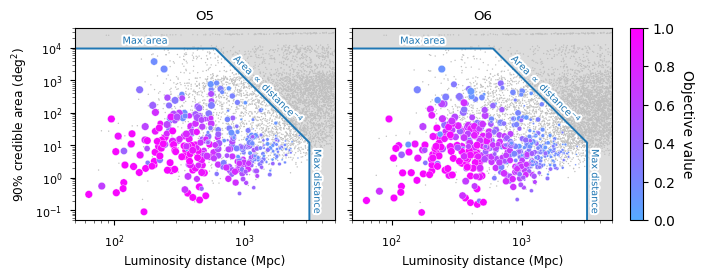

In [388]:
cmap = plt.get_cmap('cool')
cmap = LinearSegmentedColormap.from_list('truncated_cool', cmap(np.linspace(1/3, 1)))
with plt.style.context('seaborn-v0_8-paper'):
    fig = plt.figure(figsize=(7 + 1/3, 2.5), tight_layout=True)
    gs = plt.GridSpec(1, 3, figure=fig, width_ratios=(1, 1, 0.05), wspace=0.1)
    ax = fig.add_subplot(gs[0], aspect=0.25)
    # fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, tight_layout=True, figsize=(7 + 1/3, 3), subplot_kw=dict(aspect=0.25))
    # ax = axs[0]
    ax.set_xlim(5e1, 5e3)
    ax.set_ylim(5e-2, u.spat.to(u.deg**2))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(f'{skymap_area_cl}% credible area (deg$^2$)')
    axs = [ax]
    ax = fig.add_subplot(gs[1], sharex=ax, sharey=ax, aspect=0.25)
    plt.setp(ax.yaxis.get_ticklabels(), visible=False)
    ax.yaxis.get_label().set_visible(False)
    axs.append(ax)

    for ax, (run, event_table) in zip(axs, event_tables_by_run.items()):
        ax.set_xlabel('Luminosity distance (Mpc)')
        ax.fill_between(
            u.Quantity([ax.get_xlim()[0] * u.Mpc, crossover_distance, max_distance, max_distance, ax.get_xlim()[1] * u.Mpc]).to_value(u.Mpc),
            u.Quantity([max_area, max_area, min_area, ax.get_ylim()[0] * u.deg**2, ax.get_ylim()[0] * u.deg**2]).to_value(u.deg**2),
            np.tile(ax.get_ylim()[1], 5),
            color='gainsboro'
        )
        ax.scatter('distance', f'area({skymap_area_cl})', s=1, facecolor='silver', edgecolor='none', data=event_table)
        scatter = ax.scatter('distance', f'area({skymap_area_cl})', s=event_table['detection_probability_known_position'] * 30, c=event_table['objective_value'], cmap=cmap, vmin=0, vmax=1, edgecolor='white', data=event_table)
        lines, = ax.plot(
            u.Quantity([ax.get_xlim()[0] * u.Mpc, crossover_distance, max_distance, max_distance]).to_value(u.Mpc),
            u.Quantity([max_area, max_area, min_area, ax.get_ylim()[0] * u.deg**2]).to_value(u.deg**2),
            color='tab:blue'
        )
        kwargs = dict(
            color=lines.get_color(),
            ha='center',
            va='bottom',
            rotation_mode='anchor',
            linespacing=0.1,
            path_effects=[patheffects.withStroke(linewidth=3, foreground='white')],
            fontsize=0.8 * plt.rcParams['axes.labelsize']
        )
        ax.text(np.sqrt(ax.get_xlim()[0] * crossover_distance.to_value(u.Mpc)), max_area.to_value(u.deg**2), 'Max area\n', **kwargs)
        ax.text(max_distance.to_value(u.Mpc), np.sqrt(ax.get_ylim()[0] * min_area.to_value(u.deg**2)), 'Max distance\n', rotation=-90, **kwargs)
        ax.text(np.sqrt(crossover_distance.to_value(u.Mpc) * max_distance.to_value(u.Mpc)), np.sqrt(min_area.to_value(u.deg**2) * max_area.to_value(u.deg**2)), 'Area $\propto$ distance$^{-4}$\n', rotation=-45, **kwargs)
        ax.set_title(run[:2])
cbar = plt.colorbar(scatter, cax=fig.add_subplot(gs[2]))
cbar.set_label('Objective value', rotation=-90, va='bottom')
fig.savefig('../figures/area-distance.pdf')

In [73]:
log_simulation_effective_rate_by_run = {}
for run in runs:
    with sqlite3.connect(f"file:{base_path / run / 'farah' / 'events.sqlite'}?mode=ro", uri=True) as db:
        (comment,), = db.execute("SELECT comment FROM process WHERE program = 'bayestar-inject'")
    log_simulation_effective_rate_by_run[run] = np.log(u.Quantity(comment).to_value(u.Gpc**-3 * u.yr**-1))
log_simulation_effective_rate_by_run

{'O5HLVK': np.float64(7.905574365740185),
 'O6HLVK': np.float64(7.905574365740185)}

In [70]:
# O3 R&P paper Table II row 1 last column:
# 5%, 50%, and 95% quantiles of the total merger rate
# in Gpc^-3 yr^-1.
# See https://doi.org/10.1103/PhysRevX.13.011048
lo = 100
mid = 240
hi = 510

standard_90pct_interval, = np.diff(stats.norm.interval(0.9))
log_target_rate_mu = np.log(mid)
log_target_rate_sigma = np.log(hi / lo) / standard_90pct_interval
log_target_rate_mu, log_target_rate_sigma

(np.float64(5.480638923341991), np.float64(0.4952539584783209))

In [258]:
prob_quantiles = np.asarray([0.5, 0.05, 0.95])
run_duration = 1.5  # years
mu = np.asarray([
    log_target_rate_mu + np.log(run_duration) - log_simulation_effective_rate_by_run[run] + np.log([
        np.sum(_) for _ in [
            event_tables_by_run[run]['objective_value'] > 0,
            event_tables_by_run[run]['detection_probability_known_position'],
        ]
    ]) for run in runs
])

rate_quantiles = poisson_lognormal_rate_quantiles(prob_quantiles[np.newaxis, np.newaxis, :], mu.T[:, :, np.newaxis], log_target_rate_sigma)

with open('../tables/selected-detected.tex', 'w') as f:
    for i, (label, row) in enumerate(zip(['Number of events selected', 'Number of events detected'], rate_quantiles)):
        print(label, *('${}_{{-{}}}^{{+{}}}$'.format(*format_with_errorbars(*col)) for col in row), sep=' & ', end=' \\\\\n' if i < len(runs) - 1 else '\n', file=f)

In [256]:
with open('../tables/selected-detected.tex', 'w') as f:
    for i, (label, row) in enumerate(zip(['Number of events selected', 'Number of events detected'], rate_quantiles)):
        print(label, *('${}_{{-{}}}^{{+{}}}$'.format(*format_with_errorbars(*col)) for col in row), sep=' & ', end=' \\\\\n' if i < len(runs) - 1 else '\n', file=f)

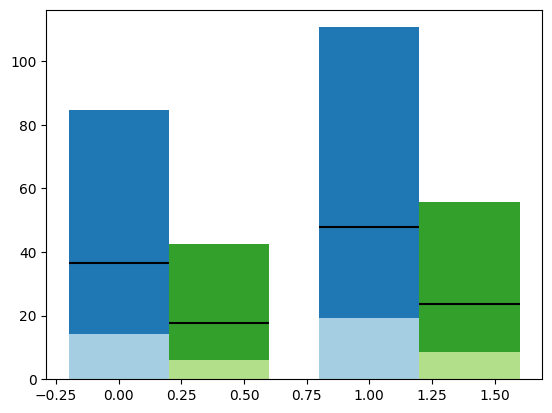

In [211]:
colors = sns.color_palette('Paired')
xlabels = [run[:2] for run in runs]

ax = plt.axes()
# ax.bar(xlabels, rate_quantiles[0, :, 2])
# ax.bar(xlabels, rate_quantiles[0, :, 0])
x = np.arange(2)
width = 0.4
offset = 0.4
ax.bar(x, rate_quantiles[0, :, 2], width=width, color=colors[1])
ax.bar(x, rate_quantiles[0, :, 1], width=width, color=colors[0])
ax.hlines(rate_quantiles[0, :, 0], x - 0.5 * width, x + 0.5 * width, color='black')
ax.bar(x + offset, rate_quantiles[1, :, 2], width=width, color=colors[3])
ax.bar(x + offset, rate_quantiles[1, :, 1], width=width, color=colors[2])
ax.hlines(rate_quantiles[1, :, 0], x + offset - 0.5 * width, x + offset + 0.5 * width, color='black')


[Text(0, 0, 'O5'), Text(1, 0, 'O6')]

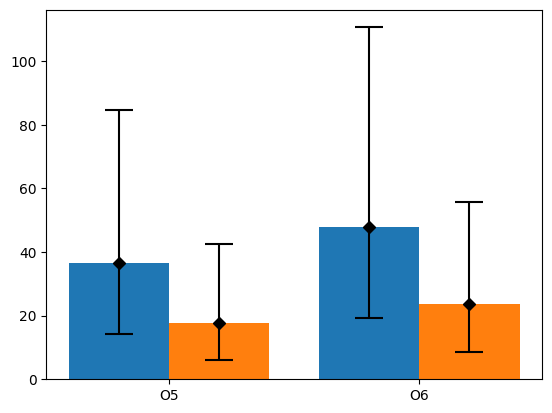

In [250]:
ax = plt.axes()
x = np.arange(2)
width = 0.4
ax.bar(x - width / 2, rate_quantiles[0, :, 0], width=width)
ax.bar(x + width / 2, rate_quantiles[1, :, 0], width=width)
ax.errorbar(x - width / 2, rate_quantiles[0, :, 0], np.vstack((rate_quantiles[0, :, 0] - rate_quantiles[0, :, 1], rate_quantiles[0, :, 2] - rate_quantiles[0, :, 0])), color='k', marker='D', linestyle='none', capsize=10, capthick=plt.rcParams['lines.linewidth'])
ax.errorbar(x + width / 2, rate_quantiles[1, :, 0], np.vstack((rate_quantiles[1, :, 0] - rate_quantiles[1, :, 1], rate_quantiles[1, :, 2] - rate_quantiles[1, :, 0])), color='k', marker='D', linestyle='none', capsize=10, capthick=plt.rcParams['lines.linewidth'])
ax.set_xticks(x)
ax.set_xticklabels([run[:2] for run in runs])

In [93]:
event_tables_by_run['O5HLVK'][np.isnan(event_tables_by_run['O5HLVK']['detection_probability_unknown_position'])]

coinc_event_id,simulation_id,far,snr,searched_area,searched_prob,searched_prob_dist,searched_vol,searched_prob_vol,offset,runtime,distmean,diststd,log_bci,log_bsn,area(20),area(50),area(90),dist(20),dist(50),dist(90),vol(20),vol(50),vol(90),longitude,latitude,inclination,distance,mass1,mass2,spin1z,spin2z,objective_value,detection_probability,detection_probability_known_position,detection_probability_unknown_position
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
223,223,0.0,15.09896859546148,36.35190600820738,0.4359880751914536,0.8034909189226755,143288.49656521127,0.5044770674658553,12.573052442407088,117.80523531790823,269.08241135888534,68.17983479441341,7.486608059518993,53.41246590179984,13.515293128986617,44.46319595905442,153.7480201275327,32.718911513164585,87.44411881528302,220.0756814864122,35413.28145967347,140939.17400860367,706809.6052367914,5.5748131,1.0463169,2.6177128,324.1169,1.7488173,1.5546045,-0.12185999,-0.10312933,0.3063216741430614,0.0,0.0,nan
4742,4742,0.0,18.96359574060851,2.9080213410246576,0.05545281890218675,0.5764002107600907,12175.852600934013,0.07711237062164329,5.020331810413023,66.06416793446988,253.36662817747018,71.62644323086113,7.672685556040705,97.56904927116025,12.134951525451843,42.14292498017923,170.35444694320975,38.90128147953999,101.63134433591983,233.8192430965641,35830.35725641443,123536.18428780997,564982.5742426646,5.2576699,1.4085946,0.73698094,265.50525,2.7178884,1.4088274,0.90871235,0.25689419,0.34173837116553385,0.7457495391317084,0.7457495391317084,nan


In [ ]:
event_table[(event_table['objective_value'] > 0.5) & (event_table['area(90)'] > 100) & (event_table['distance'] > 200) & (event_table['distance'] < 500)]

In [ ]:
event_id = 800
exptimes = np.arange(300, 3700, 100)
fixed_exptime_plans = [QTable.read(base_path / 'allsky' / f'{event_id}-exptime-{exptime}s.ecsv') for exptime in tqdm(exptimes)]

In [ ]:
prob_adaptive, *probs = [get_detection_probability_unknown_position(plan) for plan in tqdm([plans[event_id]] + fixed_exptime_plans)]